In [3080]:
#import user modules
import helper_functions as hfun
import config as cf
import thouless_times as thouless
import plot_spectrals as spec_fun
import importlib
importlib.reload(hfun)
importlib.reload(cf)
importlib.reload(thouless)
importlib.reload(spec_fun)

#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym

print(cf.base_directory)


user_settings = getattr(cf.plot_settings, 'settings')

../results/Heisenberg/disorder/PBC/


### AGP plot function 

In [3081]:
def plot_agp(axis=None, settings_class = None, which=1):
    
    if which < 1 or which > 4: 
        print("Parameter 'which' entered with illegal value")
        return
    #-- main settings
    if settings_class == None:
        settings_class = cf.plot_settings
    settings = getattr(settings_class, 'settings')
    dir = cf.base_directory + "AGP" + kPSep
    param_copy = copy.deepcopy(cf.params_arr)

    #--- prepare scaling - axis
    vals = spec_fun.get_scaling_array(settings=settings)

    y_min = 1.0e10;     y_max = -1.0e10;
    x_min = 1.0e10;     x_max = -1.0e10;
    #--- load data and plot one-by-one
    print(vals)
    for x in vals:
        cf.params_arr[settings['scaling_idx']] = x
        if settings['scaling_idx'] == 3 and cf.J0 == 0 and cf.g0 == 0:
            cf.params_arr[4] = int(100 * x / 2.) / 100.
        filename = (hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs']) + ".dat" if cf.hamiltonian else hfun.remove_info(hfun.info_param(cf.params_arr), 'J', settings['vs']) + ".dat")

        if settings['scaling_idx'] == 5 and settings['operator'] < 8:
            filename = dir + cf.operator_names[settings['operator']] + "%d"%x + kPSep + filename
        elif settings['scaling_idx'] == 0 and settings['site'] < 0:
            filename = dir + cf.operator_names[settings['operator']] + "%d"%(x/2) + kPSep + filename
        else :
            filename = dir + cf.op_name + kPSep + filename

        filename2 = cf.base_directory + "STATISTICS" + kPSep + hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs']) + ".dat"
        if exists(filename):
            data = pd.read_table(filename, sep="\t", header=None)
            if "nan" in data[1][1]: continue
            stats = pd.read_table(filename2, sep="\t", header=None)
            wH = (np.array(stats[5][1:])).astype(np.float)
            xdata = (np.array(data[0][1:])).astype(np.float)
            ydata = (np.array(data[which][1:])).astype(np.float) * binom(x, x/2) * np.power(wH, 2.0) / x
            axis.plot(xdata, ydata, label=hfun.key_title(x, settings))
            
            #-- xy-ranges
            mini = ydata.min();  maxi = ydata.max();
            if mini < y_min and np.isfinite(mini): y_min = mini
            if maxi > y_max and np.isfinite(maxi): y_max = maxi
            mini = xdata.min();  maxi = xdata.max();
            if mini < x_min and np.isfinite(mini): x_min = mini
            if maxi > x_max and np.isfinite(maxi): x_max = maxi
    ylab = ""
    if which == 1:
        ylab = "||\\mathcal{A}(A)||^2 / D"
    elif which == 2:
        ylab = "D\\cdot\\omega_H^2\\cdot\\chi^{typ}(A) / L"
    elif which == 3:
        ylab = "\\chi(A)"
    else :
      ylab = "||A||^2_{diag}"  
    hfun.set_plot_elements(axis = axis, xlim = (x_min, x_max), 
                                    ylim = (0.95*y_min, 1.05*y_max), ylabel = ylab, xlabel = settings['vs'], settings=settings, font_size=8)
  
    
    title = ""
    if (settings['vs_idx'] == 3 or settings['scaling_idx'] == 3) and cf.J0 == 0 and cf.g0 == 0 and cf.h != 0:
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'], 'w') + ',w=0.5h'
    else :
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'])
    if settings['vs_idx'] != 2 :
        try : 
            title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g
            #title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g0
        except ValueError:
                print("not found")
    axis.title.set_text(r"$%s$"%title[1:])
    axis.title.set_fontsize(10)
    #---Thouless times
    
    #--- reset defaults
    cf.params_arr = param_copy

# PLOT SPECTRAL FUNCTIONS

No handles with labels found to put in legend.


[12 14 16 18]
[16, 1.0, 0.55, 0.0, 0.7, 0, 1, 1, 0.0, 0.0]
[12 14 16 18]


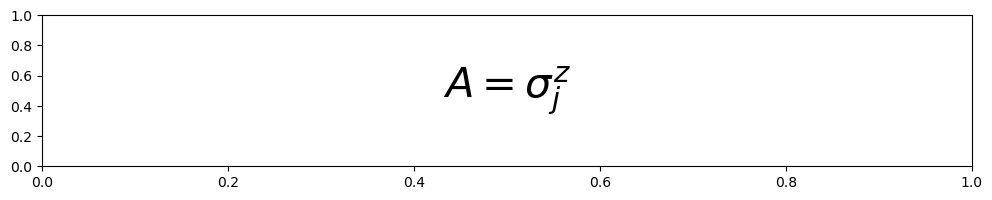

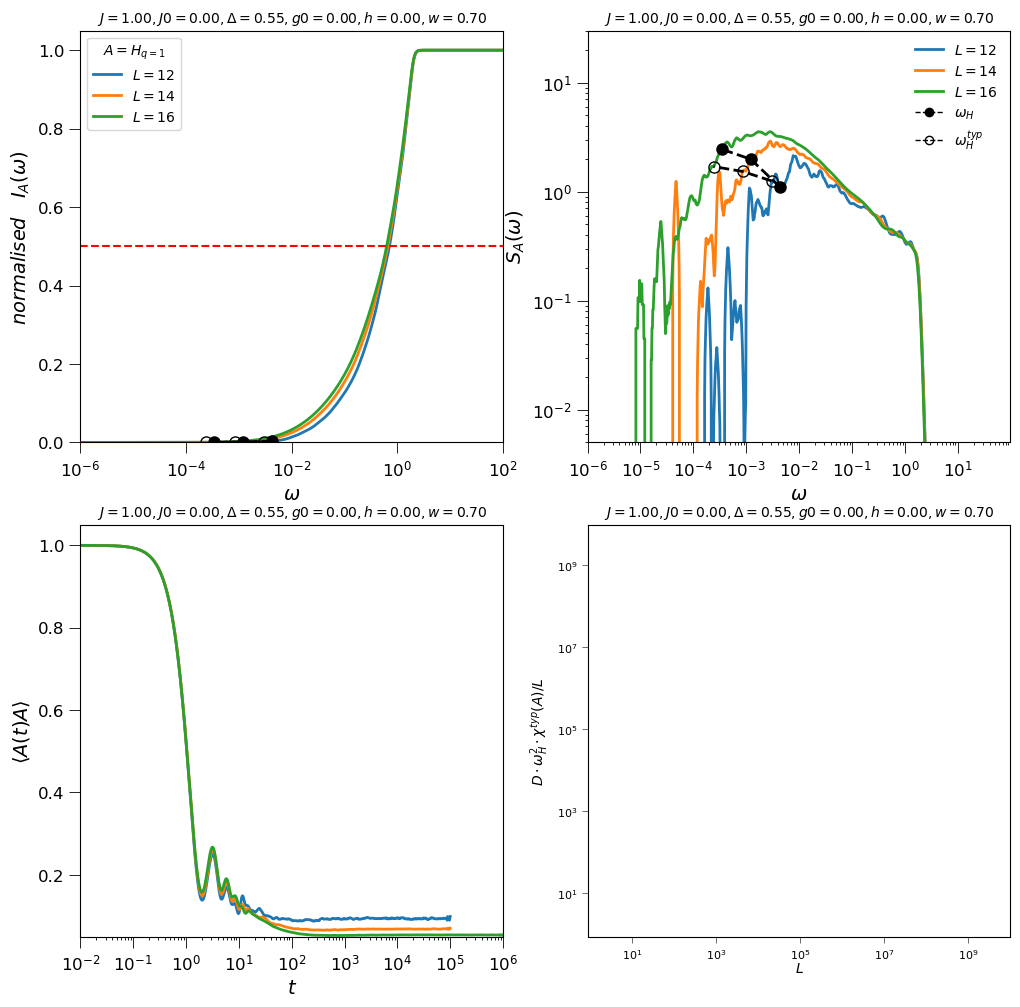

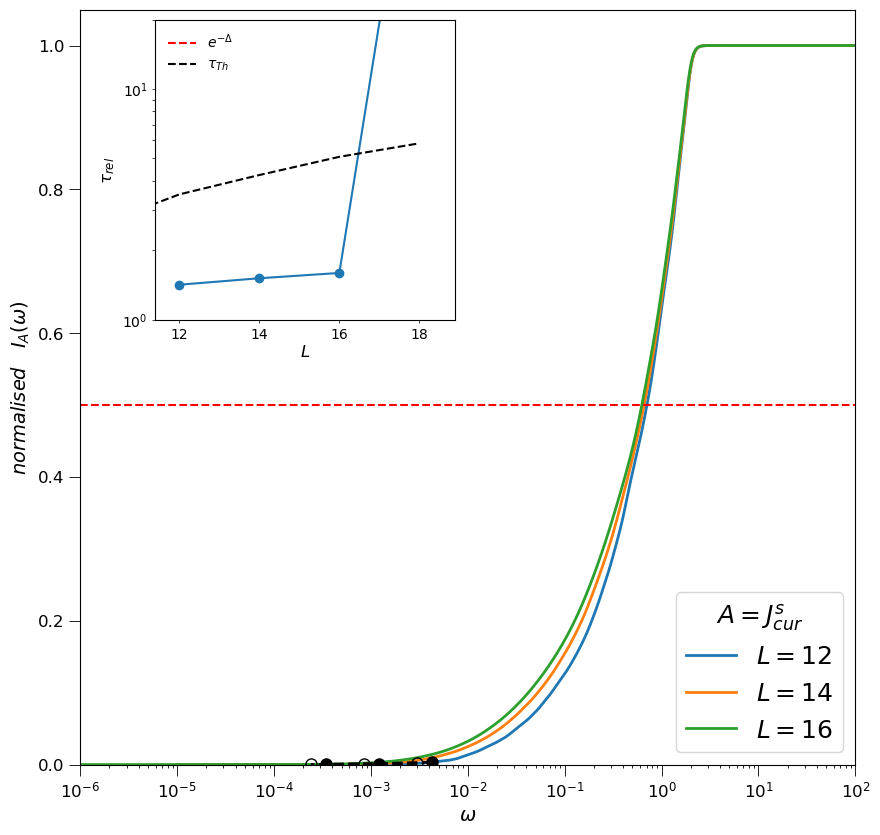

In [3082]:
use_derivative = 0
from matplotlib.lines import Line2D
def add_legend(axis):
    legend = axis.legend()
    #ax = legend.axes

    handles, labels = axis.get_legend_handles_labels()
    if user_settings['scaling'] == 'k':
        new_lab = []
        for label in labels:
            label = list(label)
            label[1] = 'q'
            new_lab.append("".join(label))
        labels = new_lab
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='o', color='black'));   labels.append(r"$\omega_H$")
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='o', color='black', markerfacecolor='None'));   labels.append(r"$\omega^{typ}_H$")
    #handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='s', color='black'));   labels.append(r"$\omega_{Th}$")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
    axis.legend(handles, labels, frameon=False, loc='best', fontsize=10)

time_dir = cf.base_directory + "timeEvolution%s"%kPSep
int_dir = cf.base_directory + "IntegratedResponseFunction%s"%kPSep
spec_dir = cf.base_directory + ("IntegratedResponseFunction%sDERIVATIVE%s"%(kPSep,kPSep) if use_derivative else "ResponseFunction%s"%kPSep)
agp_dir = cf.base_directory + "AGP{kPSep}" + cf.op_name + kPSep;

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,2), dpi = 100)
axis.annotate(r"$A=$"+cf.operator_formuals[user_settings['operator']], xy=(0.5, 0.5), color='black', size=30, ha='center', va='center')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(12,12), dpi = 100)
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,10), dpi = 100)
func = lambda y, x: y

#---------------------- TIME EVOLUTION
spec_fun.plot_spectral(axis = ax3, dir = time_dir, settings=user_settings, xlab="t", ylab="\\langle A(t)A\\rangle", yscale='linear', normalise=False)
#add_legend(axis=ax3)

#---------------------- INTEGRATED SPECTRAL FUNCTION
spec_fun.plot_spectral(axis = ax1, dir = int_dir, settings=user_settings, xlab="\\omega", ylab="I_A(\\omega)", yscale='linear', normalise=True)
add_legend(axis=ax1)
ax1.axhline(y=0.5, ls='--', color='red')
ax1.legend(title=r"$A=H_{q=1}$")

spec_fun.plot_spectral(axis = axis, dir = int_dir, settings=user_settings, xlab="\\omega", ylab="I_A(\\omega)", yscale='linear', normalise=True, func_x=func)
add_legend(axis=axis)
axis.axhline(y=0.5, ls='--', color='red')
leg = axis.legend(title=r"$A=J^s_{cur}$", fontsize=18, loc='lower right')
leg.get_title().set_fontsize('18')
axis.title.set_text("")
#axis.set_xlim(1e-3,1e1)
#---------------------- SPECTRAL FUNCTION
spec_fun.plot_spectral(axis = ax2, dir = spec_dir, settings=user_settings, xlab="\\omega", ylab="S_A(\\omega)", yscale='log', func_x=func, seper="\t")
ax2.set_ylim(5e-3, 3e1)
add_legend(axis=ax2)
#xval=np.logspace(-6,1,100)
#ax2.plot(xval, 3e3*xval, linestyle='--', color='black')
#ax2.plot(xval, 3e0/xval, linestyle='--', color='black')
#ax2.plot(xval, 3e0/xval**2, linestyle='--', color='red')
# Thouless energy

left, bottom, width, height = [0.2, 0.57, 0.3, 0.3]
axis2 = fig.add_axes([left, bottom, width, height])
vals = spec_fun.get_scaling_array(settings=user_settings)
print(vals)
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(user_settings['scaling'])
new_set_class.set_scaling('L')
#cf.set_params(_w=0.1)
tau_data = thouless.load(getattr(new_set_class, 'settings'))
idx = list(tau_data[0]).index(cf.L)
x_for_tau = tau_data[1][idx]
taus = tau_data[2][idx]
relax_time = []
for i in range(0, len(vals)):
    x = vals[i]
    xdata = axis.lines[i].get_xdata()
    ydata = axis.lines[i].get_ydata()
    idx = min(range(len(ydata)), key=lambda i: abs(ydata[i] - 0.5));
    relax_time.append(1. / xdata[idx])
relax_time = np.array(relax_time)
trueQ = 2 * vals / cf.L if user_settings['scaling_idx'] == 5 else vals
xlab = "q/\\pi" if user_settings['scaling_idx'] == 5 else user_settings['scaling']

axis2.plot(trueQ, relax_time, marker='o')
axis2.plot(trueQ, 5*np.exp(-trueQ**1.), linestyle='--', color='red', label=r"$e^{-\Delta}$")

if user_settings['scaling_idx'] == 5: 
    axis2.axhline(y=taus[0], ls='--', color='black')
    axis2.annotate("$\it{Thouless}\ \it{Time}$", xy=(0.3,1.5e3), color='black', size=12)
else: 
    axis2.plot(x_for_tau, taus, linestyle='--', color='black', label=r"$\tau_{Th}$")

hfun.set_plot_elements(axis = axis2, xlim = (0.95*min(trueQ), 1.05*max(trueQ)), 
                                    ylim = (1e0, 2e1),ylabel = "\\tau_{rel}", xlabel = xlab, settings=getattr(new_set_class, 'settings'), font_size=10, set_legend=True)
  
axis2.set_yscale('log')
axis2.set_xscale('linear')
axis2.tick_params(axis='both', which='both',length=2)
#axis2.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
#def format_func(value, tick_number):
#    return "%.1f"%value
#def format_func2(value, tick_number):
#    return "%d"%value
#axis2.xaxis.set_minor_formatter(plt.FuncFormatter(format_func))
#axis2.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
#axis2.yaxis.set_major_formatter(plt.FuncFormatter(format_func2))

#ax2.plot(taus, spec_at_tau, linestyle='--', marker='s', color='black')
#ax1.plot(taus2, int_at_tau, linestyle='--', marker='s', color='black')
#ax3.plot(1. / taus2, time_at_tau, linestyle='--', marker='s', color='black')
#
#---------------------- ADIABATICS
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(cf.plot_settings.settings['scaling'])
new_set_class.set_scaling("L")
new_set_class._settings['site'] = -1
new_set_class.set_scales(xscale='log', yscale='log')
plot_agp(axis = ax4, settings_class=new_set_class, which=2)
#ax4.set_ylim(1e2, 1e5)

(1e-05, 0.01)

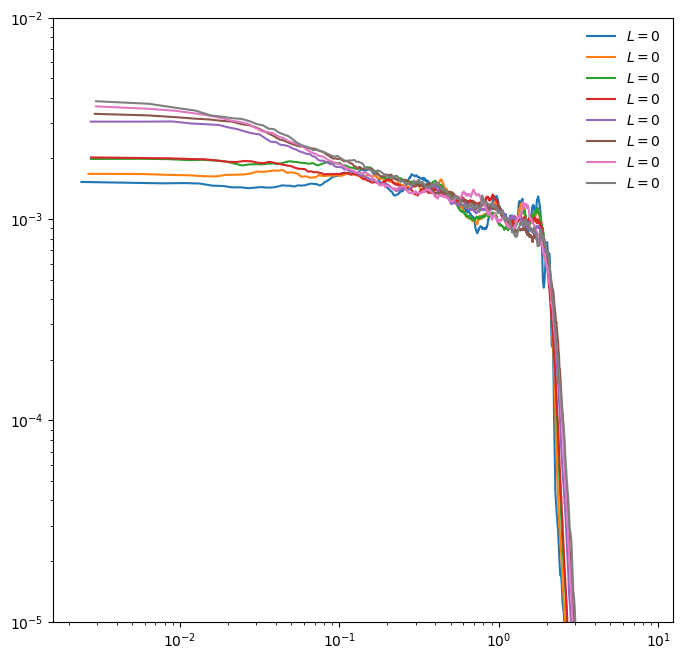

In [3083]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(8,8), dpi = 100)

vals = []
for x in range(0, 20): vals.append(0.2 + x * 0.1)
for w in vals:
    filename = "SigmaZ_j=1_L=12,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=%.2f.dat"%w
    if exists(filename):
        data = pd.read_table(filename, sep="\t", header=None)
        ax.plot(data[0], data[1], label=hfun.key_title(w, user_settings))
ax.legend(frameon=False
                , loc='best'
                , fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e-2)